# Generation of persistance images

Using 50 PCA components of the magnitudes of the Fourier Series of a wave signal, generate the image of H1 using a sample of 300 'records'


In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Librerias GTDA
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
import plotly.graph_objects as go
#from nolitsa import dimension, delay (nolitsa==0.1)

import math
import gudhi
import ripser
from persim import plot_diagrams, PersistenceImager



In [2]:
plt.rcParams.update(plt.rcParamsDefault) #Run this if the plots are not showing correctly

# Model with pca of Fourier series

##### Preprocessing

In [2]:
def compute_frequency_domain(signals, start_idx, end_idx, sampling_rate=1.0):
    frequency_domain_data = []
    for i in range(start_idx, end_idx):
        # Compute the FFT of the signal
        signal_fft = fft(signals[i])
        # Compute the corresponding frequencies
        frequencies = fftfreq(len(signal_fft), d=1/sampling_rate)
        # Filter frequencies and magnitudes in the range -0.05 to 0.05
        filtered_indices = np.where((frequencies >= -0.05) & (frequencies <= 0.05))
        filtered_frequencies = frequencies[filtered_indices].tolist()
        filtered_magnitudes = np.abs(signal_fft)[filtered_indices].tolist()
        # Store filtered frequencies and magnitudes
        frequency_domain_data.append({
            'Signal': i+1, 
            'Frequencies': filtered_frequencies, 
            'Magnitudes': filtered_magnitudes
        })
    return frequency_domain_data

def procesamiento_pca(datos_np, hacerPCA: bool=True):
    frequency_domain_results = compute_frequency_domain(datos_np, start_idx=0, end_idx=len(datos_np), sampling_rate=1.0)

    # Convert the results into a DataFrame
    frequency_domain_df = pd.DataFrame(frequency_domain_results)

    # Extracting magnitudes of Fourier series data
    magnitudes = frequency_domain_df['Magnitudes'].values

    # Reshaping magnitudes to match the expected input shape for t-SNE
    reshaped_magnitudes = np.vstack(magnitudes)

    # Normalize the data
    scaler = StandardScaler()
    normalized_magnitudes = scaler.fit_transform(reshaped_magnitudes)

    #En caso de poner false
    pca_result = normalized_magnitudes

    # Optionally apply PCA before t-SNE
    if hacerPCA:
        pca = PCA(n_components=50)
        pca_result = pca.fit_transform(normalized_magnitudes)
    

    return pca_result

# Generating the persistance images

In [4]:
datos_np = np.load('data/noisy_signals_0.3.npy')
labels = np.load('data/labels_0.3.npy')
X = procesamiento_pca(datos_np,hacerPCA=False)
X.shape

(1500, 869)

In [3]:
def crearimagen(cantidad:int): #This function creates the persistence images for the first quantity of signals in the dataset
    lista_vectores=[] #save all the  persistence diagrams
    for i in range(cantidad):
        x_periodic = np.linspace(0, 10, 869)
        y_periodic = X[i] #Select all the values in the time series

        tau=2
        d=4
        embedder_periodic = SingleTakensEmbedding(
            parameters_type="fixed",
            time_delay=tau,
            dimension=d,
        )
        y_periodic_embedded = embedder_periodic.fit_transform(y_periodic) #Embed the time series


        #Generate an array of random indexes from y_periodic_embedded so generating the images takes less time
        np.random.seed(0)
        random_indexes = np.random.randint(0, y_periodic_embedded.shape[0], 300)
        #Sort the random indexes array
        random_indexes.sort()
        #Generate the persistence diagram with the selected samples
        y_periodic_sel = y_periodic_embedded[random_indexes]
        ripserperiod = ripser.ripser(y_periodic_sel, distance_matrix=False)["dgms"]
        diagrams= ripserperiod[1].copy()
        
        lista_vectores.append(diagrams)
        if i % 500 == 0:  # Print every 100 iterations
            print(i)
        



    #Los siguientes parámetros mantienen el tamaño de la imagen de persistencia (matriz)
    birth_range = (0, 2.5)  
    pers_range = (0, 1)   
    
    # Generate the images for all the persistence diagrams at once to assure the same pixel size
    pimgr = PersistenceImager(pixel_size=0.01,birth_range=birth_range, pers_range=pers_range)
    pimgr.kernel_params = {'sigma': 0.001}
    pdgms = lista_vectores
    #pimgr.fit(lista_vectores, skew=True)
    pimgs = pimgr.transform(pdgms,skew=True)

   
    
    #return pimgs,pdgms
    return pimgs

In [6]:
imagenes=crearimagen(1500)


0
500
1000


In [7]:
imagenes=np.array(imagenes)
print(imagenes.shape)

(1500, 250, 100)


Show sample image

In [150]:
for i in range(10):
    print(labels[i])

1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0


<Axes: xlabel='birth', ylabel='persistence'>

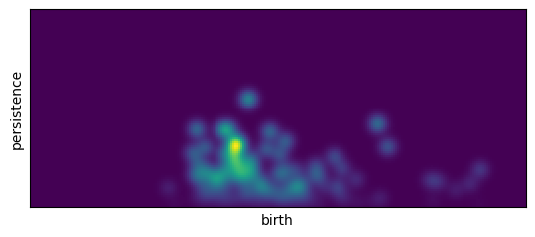

In [151]:
pimgr = PersistenceImager(pixel_size=0.01)
pimgr.kernel_params = {'sigma': 0.1}
pimgr.plot_image(imagenes[0])#, ax=axs[2])

<Axes: xlabel='birth', ylabel='persistence'>

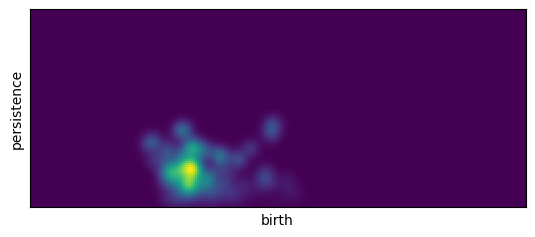

In [152]:
pimgr = PersistenceImager(pixel_size=0.01)
pimgr.kernel_params = {'sigma': 0.1}
pimgr.plot_image(imagenes[1])#, ax=axs[2])

## Save

In [8]:
#export the images to a numpy array
np.save('data/imagenes_0.3.npy', imagenes)

# Generating multiple

---

In [4]:
#list_of_R=[0.6, 0.5, 0.4, 0.2, 0.15, 0.065]
list_of_R = [0.65, 0.25]  # Updated list of R values

for i in list_of_R:
    signal='data/noisy_signals_'+str(i)+'.npy'
    label='data/labels_'+str(i)+'.npy'
    datos_np = np.load(signal)
    labels = np.load(label)
    print(signal)
    print(label)
    X = procesamiento_pca(datos_np,hacerPCA=False)
    imagenes=crearimagen(1500)
    #export the images to a numpy array
    save_dir= f'data/imagenes_{i}.npy'
    print(save_dir)
    imagenes=np.array(imagenes)
    print(imagenes.shape)
    np.save(save_dir, imagenes)
    lol=[]
    for i in range(len(imagenes)):
        lol.append(imagenes[i].flatten())
    imagenes2=np.array(lol)
    print(imagenes2.shape)
    print('===')
    
    

data/noisy_signals_0.65.npy
data/labels_0.65.npy
0
500
1000
data/imagenes_0.65.npy
(1500, 250, 100)
(1500, 25000)
===
data/noisy_signals_0.25.npy
data/labels_0.25.npy
0
500
1000
data/imagenes_0.25.npy
(1500, 250, 100)
(1500, 25000)
===


# Testing to adjust the birth and death range 

To mantain consistency on the size of the image

In [ ]:
imagenes, pdgms=crearimagen(1500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
min_first_col = []
min_second_col = []
max_first_col = []
max_second_col = []
for i in range(len(pdgms)):
    #Show the min value of pdgms[0], first column
   
    min_first_col.append(np.min(pdgms[i][:, 0]))
    min_second_col.append(np.min(pdgms[i][:, 1]))
    max_first_col.append(np.max(pdgms[i][:, 0]))
    max_second_col.append(np.max(pdgms[i][:, 1]))
    

In [7]:
min_first_col = np.array(min_first_col)
min_second_col = np.array(min_second_col)

# Print the minimum values, max values and the mean values
print("Minimum values of first column:", np.min(min_first_col))
print("Minimum values of second column:", np.min(min_second_col))
print("Maximum values of first column:", np.max(min_first_col))
print("Maximum values of second column:", np.max(min_second_col))
print("Mean values of first column:", np.mean(min_first_col))
print("Mean values of second column:", np.mean(min_second_col))

Minimum values of first column: 0.15626326203346252
Minimum values of second column: 0.19717459380626678
Maximum values of first column: 0.8313141465187073
Maximum values of second column: 0.8591821193695068
Mean values of first column: 0.4881606328090032
Mean values of second column: 0.5298332348366579


In [8]:
max_first_col = np.array(max_first_col)
max_second_col = np.array(max_second_col)

# Print the minimum values, max values and the mean values
print("Minimum values of first column:", np.min(max_first_col))
print("Minimum values of second column:", np.min(max_second_col))
print("Maximum values of first column:", np.max(max_first_col))
print("Maximum values of second column:", np.max(max_second_col))
print("Mean values of first column:", np.mean(max_first_col))
print("Mean values of second column:", np.mean(max_second_col))


Minimum values of first column: 1.2681161165237427
Minimum values of second column: 1.4454258680343628
Maximum values of first column: 3.583132028579712
Maximum values of second column: 3.6890134811401367
Mean values of first column: 2.010719648996989
Mean values of second column: 2.1586360731919605


# Ranges:

---

(0,4)
(0,4)

In [ ]:
#export the images to a numpy array
np.save('data/imagenes.npy', imagenes)

: 